# Jupyter Widgets

This tutorial covers some basic usage and examples of building rich interactive interfaces with [Jupyter widgets](https://ipywidgets.readthedocs.io/).

**Additional Resources**
- [Jupyter Widgets Documentation](https://ipywidgets.readthedocs.io/)
- Longer tutorial from the 2020 ICESat-2 Hackweek: [video](https://youtu.be/Jft9-RnmH1Y), [GitHub Repository](https://github.com/ICESAT-2HackWeek/intro-jupyter), [slides](https://docs.google.com/presentation/d/1TfY7rnCuGQDrlvsf2-P9lNADT2vwiJsdb7vmgZ3SDmA/edit?usp=sharing)


In [1]:
from IPython import display

In [2]:
display.YouTubeVideo("QEyAncC7zmQ", width=600)

## Motivating Example: Mauna Loa CO$_2$ record

Carbon Dioxide (CO$_2$) is a greenhouse gas, and significant contributor to the warming of the climate. It is an important input into climate models, which we use to make predictions about possible future climate scenarios, and sometimes to make policy decisions, including carbon taxes. 

**Question:** Based on historical CO$_2$ data, can we predict what CO$_2$ concentrations will be in the future? 

### Learning Goals
- explore the idea of "learning": building a model from data that lets us make predictions 
- introduce the principles of linear regression, a simple, but powerful method for estimating a linear model of data
- explore the impact of outliers in data on the model 
- discuss the limitations of models

### Context

Scripps institute of Oceanography has a research station at Mauna Loa in Hawaii where they have been measuring atmospheric CO$_2$ since 1958. The data we will focus on are the seasonally adjusted data. 

<img src="https://scrippsco2.ucsd.edu/assets/images/mlo_station_map.png" align="center">


**Data Source**

C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and  H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and  oceans from 1978 to 2000.  I. Global aspects, SIO Reference Series, No. 01-06, Scripps  Institution of Oceanography, San Diego, 88 pages, 2001. https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

In [1]:
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import ipywidgets as widgets

# set a larger font size for viewing 
from matplotlib import rcParams
rcParams["font.size"] = 14

### Load the data

In [2]:
if not os.path.exists("mauna_loa_data.npz"):
    import urllib.request
    tmp = urllib.request.urlretrieve(
        "https://github.com/pangeo-data/jupyter-earth/raw/master/docs/jupyter-resources/ecosystem/mauna_loa_data.npz",
        "./mauna_loa_data.npz"
    )

co2_data = np.load("mauna_loa_data.npz")
dates = co2_data["dates"]
co2 = co2_data["co2"]

print(
    f"The first year in the data is {int(dates.min())} "
    f"and the last year in the data set is {int(dates.max())}." 
)

The first year in the data is 1958 and the last year in the data set is 2020.


### Define some helper functions for fetching data

- `get_data_between`  : fetches the seasonally adjusted CO$_2$ data from Mauna Loa between `year_min` and `year_max`

- `plot_co2_data` plots the data between `year_min` and `year_max`

In [3]:
def get_data_between(year_min=1958, year_max=2020, data_type="seasonally adjusted"):
    """
    A function to fetch data between year_min and year_max  
    """
        
    # find the data between the minimimum and maximum years
    indices = (dates >= year_min) & (dates <= year_max) 
    
    return dates[indices], co2[indices]

def plot_co2_data(dates, data, ax=None):
    """
    A function that we can use to plot data between year_min and year_max
    """
    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        
    # plot data
    ax.plot(dates, data, '.',  ms=8)
    ax.grid()
    ax.set_xlabel(f"Year")
    ax.set_ylabel(f"Seasonally adjusted CO$_2$ [ppm]")
    

### Plot the whole data set

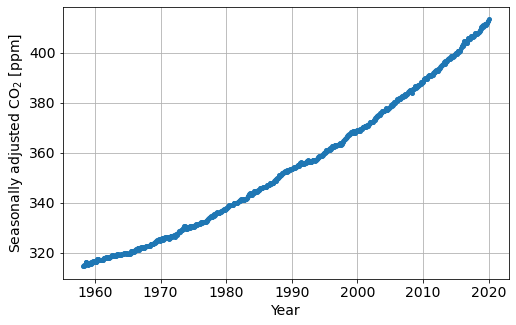

In [4]:
plot_co2_data(dates, co2)

### Focus on the first 5 years

**Question:** If the trend between 1958 and 1963 continues, what would we expect the CO$_2$ concentration to be in January, 2020?  

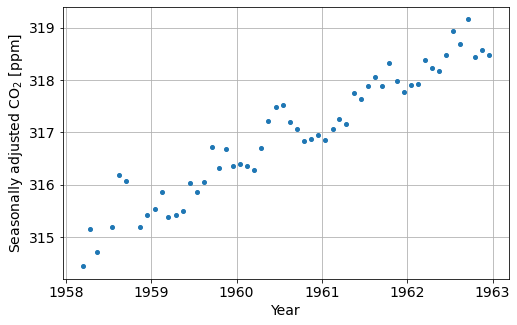

In [5]:
early_year = 1963
dates_before_early_year, co2_before_early_year = get_data_between(year_max=early_year)
plot_co2_data(dates_before_early_year, co2_before_early_year)

#### Part 1: The "eyeball" norm 

- using the widgets below, estimate a slope and intercept of a line that fits the data
- the `slope` indicates the rate of CO$_2$ accumulation per year
- the `intercept` is the estimated concentration of CO$_2$ at the first point we consider

In [6]:
def add_line(dates, slope, intercept, ax=None, label=None):
    """
    A function to add a line to a plot
    """
    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    y = slope * (dates - dates.min()) + intercept
    ax.plot(dates, y, label=label)

def plot_fit_co2_data(slope, intercept, year_min=1958, year_max=2020):
    """
    This function creates an plot that overlays a line on the CO2 data plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    dates_in_range, data_in_range = get_data_between(
        year_min=year_min, year_max=year_max
    )
    plot_co2_data(dates_in_range, data_in_range, ax=ax)
    ax.set_ylim([data_in_range.min()-1, data_in_range.max()+1])
    add_line(dates_in_range, slope, intercept, ax=ax)

In [7]:
w_early_year = widgets.interactive(
    plot_fit_co2_data, 
    slope=widgets.FloatSlider(min=0, max=5, step=0.1, value=0.8),
    intercept=widgets.FloatSlider(
        min=co2_before_early_year.min()-1, max=co2_before_early_year.max()+1, 
        step=0.25, value=315
    ),
    year_min=widgets.fixed(1958),
    year_max=widgets.fixed(early_year),
)
w_early_year

interactive(children=(FloatSlider(value=0.8, description='slope', max=5.0), FloatSlider(value=315.0, descripti…

#### Make a prediction 

Based on your estimated slope and intercept values what will the CO$_2$ concentration be in January 2020

In [8]:
predict_year = 2020

In [9]:
def predict_co2(slope, intercept, initial_date, prediction_date):
    """
    based on an estimated slope, and intercept use a linear 
    model to predict CO2 concentration
    """
    return slope * (prediction_date-initial_date) + intercept

The following lines of code grab the value of the slope and intercept from the widget above. 

In [10]:
eyeball_slope_early = w_early_year.kwargs["slope"]
eyeball_intercept_early = w_early_year.kwargs["intercept"]

Here, we use the values of the slope and intercept you estimated to predict the CO$_2$ concentration in the future. 

In [11]:
prediction_eyeball_early = predict_co2(
    eyeball_slope_early,
    eyeball_intercept_early,
    dates_before_early_year.min(),
    predict_year
)

print(
    f"Predicted CO2 in {predict_year}: {prediction_eyeball_early:1.2f} [ppm]"
)

Predicted CO2 in 2020: 370.31 [ppm]


### How does this compare with the data?  

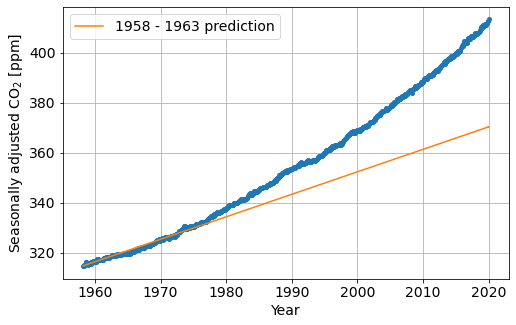

In [12]:
def plot_predictions(xlim=None, ylim=None):
    dates_to_year_predicted = np.hstack([dates, np.r_[predict_year]])

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    plot_co2_data(dates, co2, ax=ax)

    # add predictions to 2020
    add_line(
        dates_to_year_predicted, eyeball_slope_early, eyeball_intercept_early, 
        ax=ax, label=f"1958 - {early_year} prediction"
    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()

plot_predictions()

Why are these so different? 

**Q1:** Within small enough regions, the data follow an approximately linear trend, so a linear model has some predictive power. In the following cell, we have a widget where you can zoom in on the plot. 
- Out to which year would you trust the model built with the data from 1958 - 1963? 
- Where does it start to break down?

**Q2:** How far out would you trust predictions with data from 2015 - 2020?

**Q3:** How would you approach building a model to fit all of our data?

## Widgets without writing widgets

_What just happened?_ 

The `interact` function (`ipywidgets.interact`) automatically creates user interface (UI) controls for exploring code and data interactively. It is the easiest way to get started using IPython's widgets.

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Basic `interact`

At the most basic level, `interact` autogenerates UI controls for function arguments, and then calls the function with those arguments when you manipulate the controls interactively. To use `interact`, you need to define a function that you want to explore. Here is a function that triples its argument, `x`.

In [14]:
def f(x):
    return 3*x

When you pass this function as the first argument to `interact` along with an integer keyword argument (`x=10`), a slider is generated and bound to the function parameter.

In [15]:
interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

When you move the slider, the function is called, and the return value is printed.

If you pass `True` or `False`, `interact` will generate a checkbox:

In [16]:
interact(f, x=True);

interactive(children=(Checkbox(value=True, description='x'), Output()), _dom_classes=('widget-interact',))

If you pass a string, `interact` will generate a `Text` field.

In [17]:
interact(f, x='Hi there!');

interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

`interact` can also be used as a decorator. This allows you to define a function and interact with it in a single shot. As this example shows, `interact` also works with functions that have multiple arguments.

In [18]:
@interact(x=True, y=1.0)
def g(x, y):
    return (x, y)

interactive(children=(Checkbox(value=True, description='x'), FloatSlider(value=1.0, description='y', max=3.0, …

### Fixing arguments using `fixed`

There are times when you may want to explore a function using `interact`, but fix one or more of its arguments to specific values. This can be accomplished by wrapping values with the `fixed` function.

In [19]:
def h(p, q):
    return (p, q)

When we call `interact`, we pass `fixed(20)` for q to hold it fixed at a value of `20`.

In [20]:
interact(h, p=5, q=fixed(20));

interactive(children=(IntSlider(value=5, description='p', max=15, min=-5), Output()), _dom_classes=('widget-in…

Notice that a slider is only produced for `p` as the value of `q` is fixed.

### Widget abbreviations

When you pass an integer-valued keyword argument of `10` (`x=10`) to `interact`, it generates an integer-valued slider control with a range of `[-10,+3*10]`. In this case, `10` is an *abbreviation* for an actual slider widget:

```python
IntSlider(min=-10,max=30,step=1,value=10)
```

In fact, we can get the same result if we pass this `IntSlider` as the keyword argument for `x`:

In [21]:
interact(f, x=widgets.IntSlider(min=-10, max=30, step=1, value=10));

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

This examples clarifies how `interact` proceses its keyword arguments:

1. If the keyword argument is a `Widget` instance with a `value` attribute, that widget is used. Any widget with a `value` attribute can be used, even custom ones.
2. Otherwise, the value is treated as a *widget abbreviation* that is converted to a widget before it is used.

The following table gives an overview of different widget abbreviations:

<table class="table table-condensed table-bordered">
  <tr><td><strong>Keyword argument</strong></td><td><strong>Widget</strong></td></tr>  
  <tr><td>`True` or `False`</td><td>Checkbox</td></tr>  
  <tr><td>`'Hi there'`</td><td>Text</td></tr>
  <tr><td>`value` or `(min,max)` or `(min,max,step)` if integers are passed</td><td>IntSlider</td></tr>
  <tr><td>`value` or `(min,max)` or `(min,max,step)` if floats are passed</td><td>FloatSlider</td></tr>
  <tr><td>`['orange','apple']` or `[('one', 1), ('two', 2)]`</td><td>Dropdown</td></tr>
</table>
Note that a dropdown is used if a list or a list of tuples is given (signifying discrete choices), and a slider is used if a tuple is given (signifying a range).

You have seen how the checkbox and textarea widgets work above. Here, more details about the different abbreviations for sliders and dropdowns are given.

If a 2-tuple of integers is passed `(min,max)`, an integer-valued slider is produced with those minimum and maximum values (inclusively). In this case, the default step size of `1` is used.

In [22]:
interact(f, x=(0, 4));

interactive(children=(IntSlider(value=2, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

A `FloatSlider` is generated if any of the values are floating point. The step size can be changed by passing a third element in the tuple.

In [23]:
interact(f, x=(0, 10, 1));

interactive(children=(IntSlider(value=5, description='x', max=10), Output()), _dom_classes=('widget-interact',…

For both integer and float-valued sliders, you can pick the initial value of the widget by passing a default keyword argument to the underlying Python function. Here we set the initial value of a float slider to `5.5`.

In [24]:
@interact(x=(0.0, 20.0, 0.5))
def h(x=5.5):
    return x

interactive(children=(FloatSlider(value=5.5, description='x', max=20.0, step=0.5), Output()), _dom_classes=('w…

Dropdown menus are constructed by passing a list of strings. In this case, the strings are both used as the names in the dropdown menu UI and passed to the underlying Python function.

In [25]:
interact(f, x=['apples','oranges']);

interactive(children=(Dropdown(description='x', options=('apples', 'oranges'), value='apples'), Output()), _do…

If you want a dropdown menu that passes non-string values to the Python function, you can pass a list of tuples of the form `('label', value)`. The first items are the names in the dropdown menu UI and the second items are values that are the arguments passed to the underlying Python function.

In [26]:
interact(f, x=[('one', 10), ('two', 20)]);

interactive(children=(Dropdown(description='x', options=(('one', 10), ('two', 20)), value=10), Output()), _dom…

### `interactive`

In addition to `interact`, IPython provides another function, `interactive`, that is useful when you want to reuse the widgets that are produced or access the data that is bound to the UI controls.

Note that unlike `interact`, the return value of the function will not be displayed automatically, but you can display a value inside the function with `IPython.display.display`.

Here is a function that returns the sum of its two arguments and displays them.

In [27]:
from IPython.display import display

def f(a, b):
    display(a + b)
    return a+b

Unlike `interact`, `interactive` returns a `Widget` instance rather than immediately displaying the widget.

In [28]:
w = interactive(f, a=10, b=20)

The widget is an `interactive`, a subclass of `VBox`, which is a container for other widgets.

In [29]:
type(w)

ipywidgets.widgets.interaction.interactive

The children of the `interactive` are two integer-valued sliders and an output widget, produced by the widget abbreviations above.

In [30]:
w.children

(IntSlider(value=10, description='a', max=30, min=-10),
 IntSlider(value=20, description='b', max=60, min=-20),
 Output())

To actually display the widgets, you can use IPython's `display` function.

In [31]:
display(w)

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='…

At this point, the UI controls work just like they would if `interact` had been used. You can manipulate them interactively and the function will be called. However, the widget instance returned by `interactive` also gives you access to the current keyword arguments and return value of the underlying Python function. 

Here are the current keyword arguments. If you rerun this cell after manipulating the sliders, the values will have changed.

In [33]:
w.kwargs

{'a': -1, 'b': 33}

In [34]:
w.result

32

## Basic interactive plot

Though the examples so far in this notebook had very basic output, more interesting possibilities are straightforward. 

The function below plots a straight line whose slope and intercept are given by its arguments.

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

The interactive below displays a line whose slope and intercept is set by the sliders. Note that if the variable containing the widget, `interactive_plot`, is the last thing in the cell it is displayed.

In [36]:
interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

### Disabling continuous updates

When interacting with long running functions, or even with short functions whose results take some to display, realtime feedback is a burden instead of being helpful. You might have noticed the output of some of the widgets above "flickering" as you adjusted the controls. By default, `interact` and `interactive` call the function for every update of the widgets value. 

There are two ways to mitigate this.  You can either only execute on demand, or restrict execution to mouse release events.

#### `interact_manual`

The `interact_manual` function provides a variant of interaction that allows you to restrict execution so it is only done on demand.  A button is added to the interact controls that allows you to trigger an execute event.

In [37]:
def slow_function(i):
    """
    Sleep for 1 second then print the argument
    """
    from time import sleep
    print('Sleeping...')
    sleep(1)
    print(i)

interact_manual(slow_function,i=widgets.FloatSlider(min=1e4, max=1e6, step=1e4));

interactive(children=(FloatSlider(value=10000.0, description='i', max=1000000.0, min=10000.0, step=10000.0), B…

You can do the same thing with `interactive` by using the a `dict` as the second argument, as shown below.

In [38]:
foo = interactive(slow_function, {'manual': True}, i=widgets.FloatSlider(min=1e4, max=1e6, step=1e4))
foo

interactive(children=(FloatSlider(value=10000.0, description='i', max=1000000.0, min=10000.0, step=10000.0), B…

#### `continuous_update`

If you are using slider widgets, you can set the `continuous_update` kwarg to `False`.  `continuous_update` is a keyword argument of slider widgets that restricts executions to mouse release events.

In ipywidgets 7, the `Text` and `Textarea` controls also have a `continuous_update` argument.

The first example below provides the `continuous_update` argument when the widget is created.

In [39]:
interact(slow_function,i=widgets.FloatSlider(min=1e4, max=1e6, step=5e4, continuous_update=False));

interactive(children=(FloatSlider(value=10000.0, continuous_update=False, description='i', max=1000000.0, min=…

### For more information 

For more extended examples of `interact` and `interactive`, see [the example in the ipywidgets source repository](https://github.com/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Index.ipynb).